# Решение для курса "Прикладное машинное обучение"

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import catboost
import optuna

## Бизнес-постановка задачи  

Банк в рамках своей новой стратегии по удержанию клиентов решил предлагать персонализированные предложения для своих клиентов. Но предлагать уникальные условия каждому клиенту - слишком дорого, поэтому было принято решение предлагать эти условия только тем, кто в скором времени может уйти. Нужно определить, уйдёт ли клиент в этом (2020) году или нет

## Постановка ML-задачи  

На основе данных о пользователе за предыдущие 2 года построить модель, которая определит, уйдёт пользователь или нет.  
Бинарная классификация.

## Выбор метрики

В качестве метрики качества модели была выбрана ROC AUC как самая универсальная в задачах бинарной классификации.  
Эта метрика не зависит ни от модели, ни от соотношения положительных и отрицательных примеров в выборке (о соотношении - ниже). Также с помощью этой метрики легко сравнивать модели - чем больше ROC AUC, тем лучше.

## EDA

Взглянем на данные

In [66]:
data = pd.read_csv('data.csv')
data.head(10)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Trans_Ct,Quarter,Year,Date_Leave
0,708082083,Existing Customer,46,F,High School,Married,$40K - $60K,Blue,48,4,2,3,3544,943,44,none,2019,"none,2019"
1,708082083,Existing Customer,45,F,High School,Married,$40K - $60K,Blue,36,4,3,3,3544,1661,111,none,2018,"none,2018"
2,708083283,Attrited Customer,58,M,College,Single,$40K - $60K,Blue,45,3,1,3,3421,2517,21,Q4,2018,"Q4,2018"
3,708084558,Attrited Customer,60,M,Graduate,Divorced,$60K - $80K,Silver,38,6,3,3,8258,1771,23,Q2,2018,"Q2,2018"
4,708085458,Attrited Customer,35,F,Uneducated,Single,Less than $40K,Blue,36,6,2,2,1500,784,47,Q4,2019,"Q4,2019"
5,708085458,Existing Customer,34,F,Uneducated,Single,Less than $40K,Blue,24,6,2,2,"1438,3",0,82,none,2018,"none,2018"
6,708086958,Existing Customer,50,F,High School,Married,Less than $40K,Blue,53,3,1,2,3128,232,80,none,2019,"none,2019"
7,708086958,Existing Customer,49,F,High School,Married,Less than $40K,Blue,41,3,5,2,3128,749,59,none,2018,"none,2018"
8,708095133,Existing Customer,44,M,Graduate,Married,$120K +,Platinum,46,5,6,2,33304,1041,56,none,2019,"none,2019"
9,708095133,Existing Customer,43,M,Graduate,Married,$120K +,Platinum,34,5,2,2,33304,1833,29,none,2018,"none,2018"


In [67]:
print("Размер выобрки: " + str(data.shape[0]))

Размер выобрки: 20071


### Описание колонок  

**CLIENTNUM** - ID клиента;  
**Attrition_Flag** - Existing customer - активный клиент, Attrited customer - ушедший клиент;  
**Customer_Age** - Возраст;  
**Gender** - Пол;  
**Education_Level** - Уровень образования;  
**Marital_Status** - Семейное положение;  
**Income_Category** - Доход;  
**Card_Category** - Тип карты;  
**Months_on_book** - Количество месяцев пользования услугами банка;  
**Total_Relationship_Count** - Количество связей с банком;  
**Months_Inactive_12_mon** - Количество неактивных месяцев за последний год;  
**Contacts_Count_12_mon** - Количество контактов с банком за последний год;  
**Credit_Limit** - Кредитный лимит;  
**Total_Revolving_Bal** - Возобновляющийся баланс;  
**Total_Trans_Ct** - Количество транзакций;  
**Quarter** - Квартал - указан, если клиент ушёл;  
**Year** - Год;  
**Date_Leave** - Дата ухода клиента.

### Анализ колонок  

Attrition_Flag - целевая переменная. При этом Quarter и Date_Leave напрямую зависят от Attrition_Flag, поэтому должны быть исключены при обучении. 

In [68]:
existing_customer_count = data[data.Attrition_Flag == 'Existing Customer'].shape[0]
existing_customer_count_without_quarter = \
    data[(data.Attrition_Flag == 'Existing Customer') & (data.Quarter == 'none')].shape[0]
existing_customer_count_without_data_leave = \
    data[(data.Attrition_Flag == 'Existing Customer') & (data.Date_Leave.str.startswith('none'))].shape[0]

assert existing_customer_count == existing_customer_count_without_quarter
assert existing_customer_count == existing_customer_count_without_data_leave

Помимо этого стоит обратить внимание на то, что в данных смешаны наблюдения за два года - 2018 и 2019. При обучении данные нужно по особенному разбивать на test и train, а также при кроссс валидации, чтобы не допустить data leak "из будущего в прошлое".  

Ещё стоит убрать при обучении CLIENTNUM, так как полезной информации оно не несёт, а в связке с временнЫми данными может вести к переобучению.

### Чистка данных  

Можно заметить, что в колонке Credit_Limit присутствуют дробные значения, при этом pandas определил тип это колонки как "object"

In [69]:
data.Credit_Limit.dtype

dtype('O')

Преведём к флоат

In [70]:
data.Credit_Limit = data.Credit_Limit.map(lambda s: float(s.replace(",", "."))).astype(float)

## Визуальный анализ

### Распределение значений по колонкам

In [71]:
def bar_chart(column, ax):
    ax.set_title(column)
    counts = data[column].value_counts()
    ax.bar(counts.index, counts.values)


def hist_chart(column, ax):
    ax.set_title(column)
    ax.hist(data[column], bins=5)

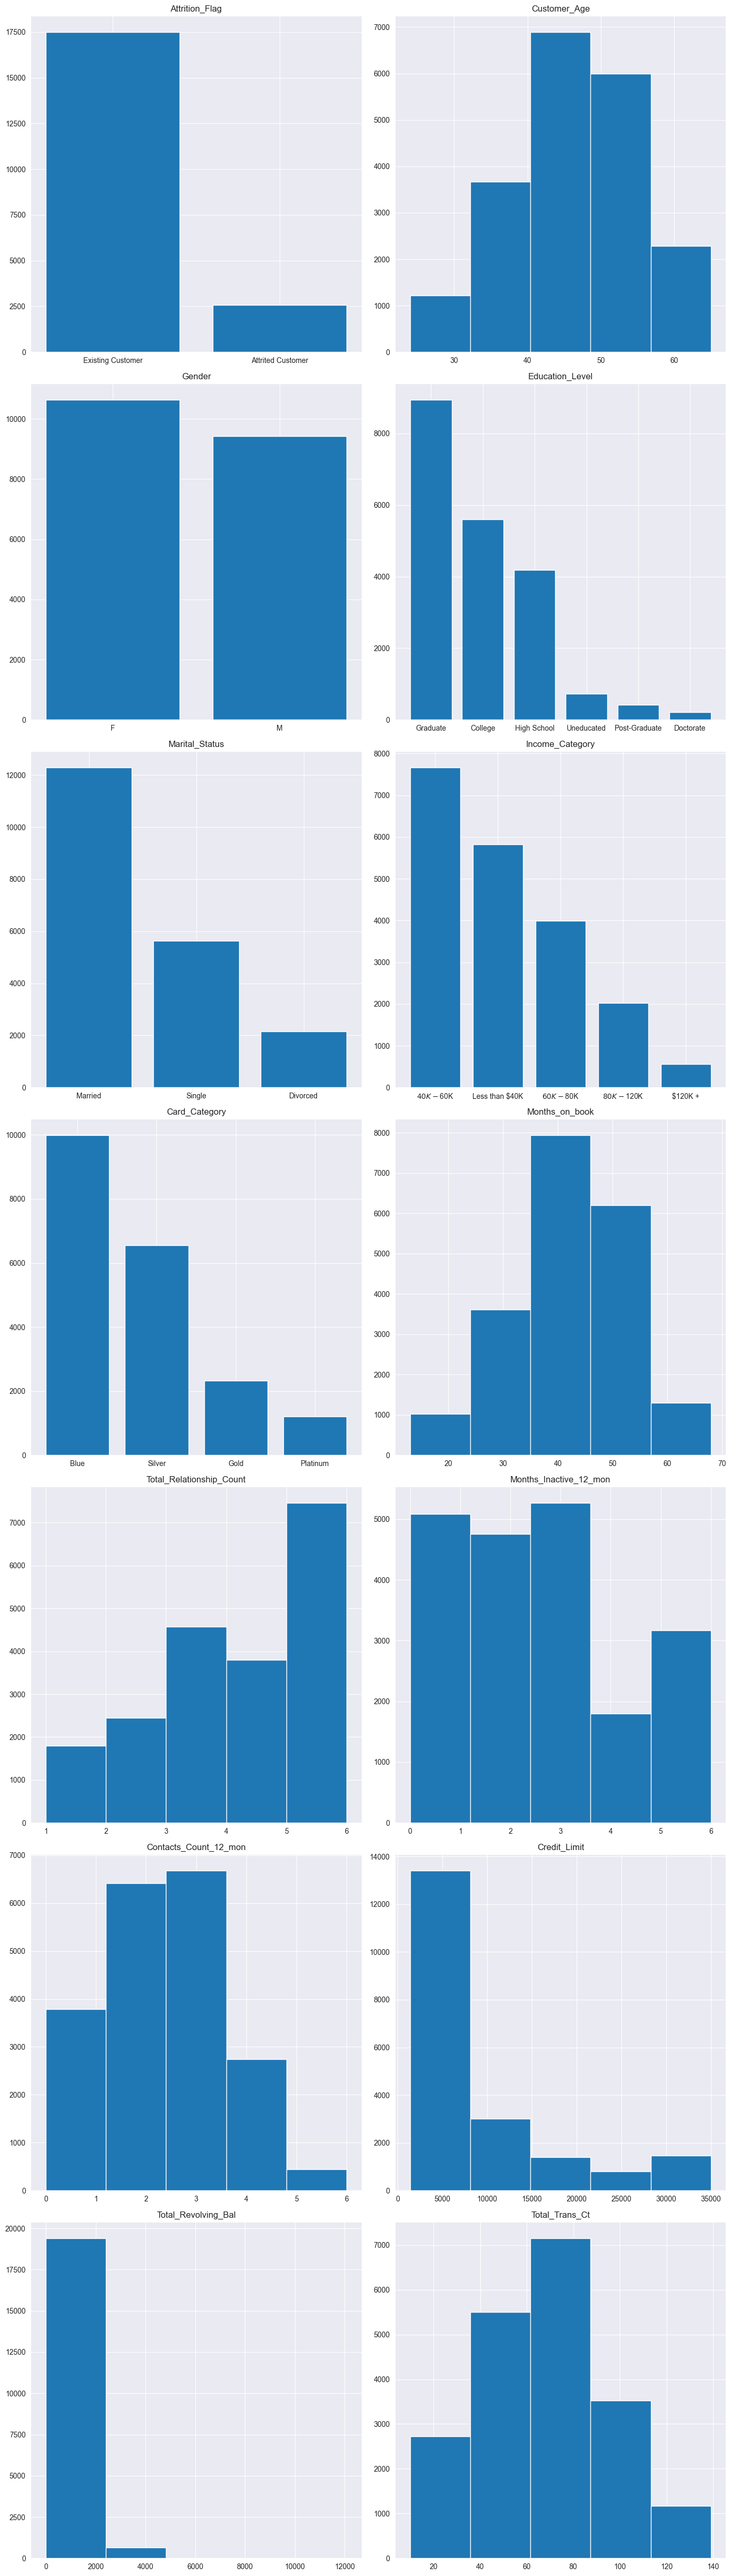

In [72]:
fig, axs = plt.subplots(7, 2, figsize=(14, 49))

bar_chart('Attrition_Flag', axs[0][0])
hist_chart('Customer_Age', axs[0][1])
bar_chart('Gender', axs[1][0])
bar_chart('Education_Level', axs[1][1])
bar_chart('Marital_Status', axs[2][0])
bar_chart('Income_Category', axs[2][1])
bar_chart('Card_Category', axs[3][0])
hist_chart('Months_on_book', axs[3][1])
hist_chart('Total_Relationship_Count', axs[4][0])
hist_chart('Months_Inactive_12_mon', axs[4][1])
hist_chart('Contacts_Count_12_mon', axs[5][0])
hist_chart('Credit_Limit', axs[5][1])
hist_chart('Total_Revolving_Bal', axs[6][0])
hist_chart('Total_Trans_Ct', axs[6][1])

plt.tight_layout()
plt.show()

В глаза сразу брасается соотношение классов: положительного класса (Attrited customer) в ~7 раз меньше, чем отрицательного (Existing customer)

### Преобразование данных

**Преобразование категориальных признаков**  
в boolean колонки, соответствующие каждому значению

In [73]:
original_data = data.copy()
categorical_columns = ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status',
                       'Income_Category', 'Card_Category']

for column in categorical_columns:
    data_encoded = pd.get_dummies(data[column], prefix=column, dtype=int)
    data = pd.concat([data, data_encoded], axis=1)

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20071 entries, 0 to 20070
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CLIENTNUM                         20071 non-null  int64  
 1   Attrition_Flag                    20071 non-null  object 
 2   Customer_Age                      20071 non-null  int64  
 3   Gender                            20071 non-null  object 
 4   Education_Level                   20071 non-null  object 
 5   Marital_Status                    20071 non-null  object 
 6   Income_Category                   20071 non-null  object 
 7   Card_Category                     20071 non-null  object 
 8   Months_on_book                    20071 non-null  int64  
 9   Total_Relationship_Count          20071 non-null  int64  
 10  Months_Inactive_12_mon            20071 non-null  int64  
 11  Contacts_Count_12_mon             20071 non-null  int64  
 12  Cred

Таким образом наша целевая переменная - Attrition_Flag_Attrited Customer

**Удаление колонок.**  
Изначальные категориальные колонки, а также бесполезные и дубликаты для таргета

In [75]:
columns_to_delete = categorical_columns + ['Quarter', 'Date_Leave', 'CLIENTNUM', 'Attrition_Flag_Existing Customer']

data.drop(columns_to_delete, axis=1, inplace=True)

### Разбиение на test и train  

Как писалось ранее, у нас есть данные за два года. Лучше провести разбиение как раз по колонке Year.  
Плюсы такого разбиения:
- Не будет 'протечки данных' из будущего в прошлого  
- Оценка метрики на трейне будет приближина к тому, как будет использоваться модель - после подведения статистики за год модель будет применятся ко всем пользователем
    
Минусы:
- Слишком большая тестовая выборка

In [76]:
train_data = data[data['Year'] == 2018]
test_data = data[data['Year'] == 2019]

y_train = train_data['Attrition_Flag_Attrited Customer']
X_train = train_data.drop(['Attrition_Flag_Attrited Customer', 'Year'], axis=1)
y_test = test_data['Attrition_Flag_Attrited Customer']
X_test = test_data.drop(['Attrition_Flag_Attrited Customer', 'Year'], axis=1)

## Обучение моделей

### Модель с константным ответом

In [77]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

model = DummyClassifier(strategy='most_frequent')

model.fit(X_train, y_train)

print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

0.5


Ожидаемо. Для любой константной модели метрика ROC AUC будет равно 0.5, несмотря на дисбаланс классов.

### Простые модели

**Случайны лес**

In [78]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

0.5036095721394088


:/  
на 0.0036 лучше чем случайная/константная модель...
Попробуем "ближайщих соседей"

**KNN**

In [79]:
from sklearn.neighbors import KNeighborsClassifier

k = 5  # количество соседей
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)

print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

0.5016236959897367


**Логистическая регресия**

In [80]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='saga', max_iter=10000, random_state=42)
model.fit(X_train, y_train)

print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

0.5368674120757686


**Выводы**

Такие плохие результаты могли получится из-за:  
- Плохой настройкой гиперпараметров
- Дизбалансом классов при обучении
- Просто недостаточно данных для решения задачи

За кадром была попытка применить нормализацию к данным, но она сделала только хуже. KNN, например, опустился ниже 0.5

## Сложная модель  
В качастве сложной модели был выбран градиентный бустинг на деревьях.  
В качестве имплементации выступает catboost

### Причины выбора данного решения  
- Композиции решающих деревьях хорошо подходят для подобных датасетов (не зря они так популярны на kaggle)
- Catboost, как и его вдохновитель XGBoost, являются одним из лучших алгоритмов ансаблей случайных деревьев.
- Хорошая поддержка категориальных признаков у catboost из коробки
- У автора имеется опыт использования catboost &#x1F601;

**Пробный запуск**  
Сначала уберём one hot encoding

In [81]:
data = original_data

data_encoded = pd.get_dummies(data['Attrition_Flag'], prefix='Attrition_Flag', dtype=int)
data = pd.concat([data, data_encoded], axis=1)
data.drop(['Attrition_Flag', 'Quarter', 'Date_Leave', 'CLIENTNUM', 'Attrition_Flag_Existing Customer'], axis=1,
          inplace=True)

train_data = data[data['Year'] == 2018]
test_data = data[data['Year'] == 2019]

y_train = train_data['Attrition_Flag_Attrited Customer']
X_train = train_data.drop(['Attrition_Flag_Attrited Customer', 'Year'], axis=1)
y_test = test_data['Attrition_Flag_Attrited Customer']
X_test = test_data.drop(['Attrition_Flag_Attrited Customer', 'Year'], axis=1)

In [83]:
from catboost import CatBoostClassifier

cat_features = ['Gender', 'Education_Level', 'Marital_Status',
                'Income_Category', 'Card_Category']

model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, logging_level='Silent', random_seed=42)
model.fit(X_train, y_train, cat_features=cat_features)

print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

ROC AUC: 0.5155374700657509


### Подбор гиперпараметров с scikit-learn методами на кросс-валидации

#### Параметры для перебора  
- learning_rate - скорость спуска градиентного спуска в бустинге;
- depth - максимальная глубина деревьев;
- iterations - количество деревьев;
- ~~l2_leaf_reg - коеффциент для L2 регуляризации листьев;~~
- ~~subsample - доля выборки, используемых для обучения отдельного дерева;~~
- ~~colsample_bylevel - доля признаков, используемых для обучения отдельного дерева;~~
- ~~border_count - количество бакетов для числовых признаков.~~

При изначальном списке время подбора было слишком большим. Поэтому были оставлены только самые основные.

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

model = CatBoostClassifier(logging_level='Silent', random_seed=42)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': [4, 6, 8, 10],
    'iterations': [100, 200, 300],
    #'l2_leaf_reg': [1, 3, 5, 7],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bylevel': [0.7, 0.8, 0.9],
    #'border_count': [32, 64, 128],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc')
grid_search.fit(X_train, y_train, cat_features=cat_features)

print("Лучшие гиперпараметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
print("ROC AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

Лучшие гиперпараметры: {'depth': 4, 'iterations': 300, 'learning_rate': 0.1}
ROC AUC: 0.5188755246761692


In [89]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'iterations': trial.suggest_int('iterations', 100, 500),
        #'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 3, 5, 7),
        #'subsample': trial.suggest_float('subsample', 0.7, 0.8, 0.9),
        #'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.7, 0.8, 0.9),
        #'border_count': trial.suggest_int('border_count', 32, 64, 128),
    }
    
    model = CatBoostClassifier(logging_level='Silent', random_seed=42, **params)
    model.fit(X_train, y_train, cat_features=cat_features)
    
    y_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)
    
    return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print("Лучшие гиперпараметры:", study.best_params)

best_params = study.best_params
best_model = CatBoostClassifier(logging_level='Silent', random_seed=42, **best_params)

best_model = grid_search.best_estimator_
print("ROC AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

[I 2024-04-22 00:56:01,060] A new study created in memory with name: no-name-cab63083-ea3c-45c5-bbf4-81e398bbbce7
[I 2024-04-22 00:56:08,132] Trial 0 finished with value: 0.4978897714090513 and parameters: {'learning_rate': 0.1719610106614796, 'depth': 10, 'iterations': 236}. Best is trial 0 with value: 0.4978897714090513.
[I 2024-04-22 00:56:12,096] Trial 1 finished with value: 0.5123502846583188 and parameters: {'learning_rate': 0.0642557621594433, 'depth': 7, 'iterations': 489}. Best is trial 1 with value: 0.5123502846583188.
[I 2024-04-22 00:56:14,713] Trial 2 finished with value: 0.5184513740797771 and parameters: {'learning_rate': 0.10867279811119411, 'depth': 6, 'iterations': 371}. Best is trial 2 with value: 0.5184513740797771.
[I 2024-04-22 00:56:17,548] Trial 3 finished with value: 0.5150445287571634 and parameters: {'learning_rate': 0.1871106372580304, 'depth': 4, 'iterations': 496}. Best is trial 2 with value: 0.5184513740797771.
[I 2024-04-22 00:56:19,256] Trial 4 finished

Лучшие гиперпараметры: {'learning_rate': 0.14987759193935818, 'depth': 4, 'iterations': 311}
ROC AUC: 0.5188755246761692


Гипер параметры выбраны очень близки в обоих случаях.

### Значимость признаков

Решающие деревья и ансабли на них - одни из лучших алгоритмов в интерпретируемости ответов. Гораздо проще других алгоритмов позволяет  получить вазжность признаков.

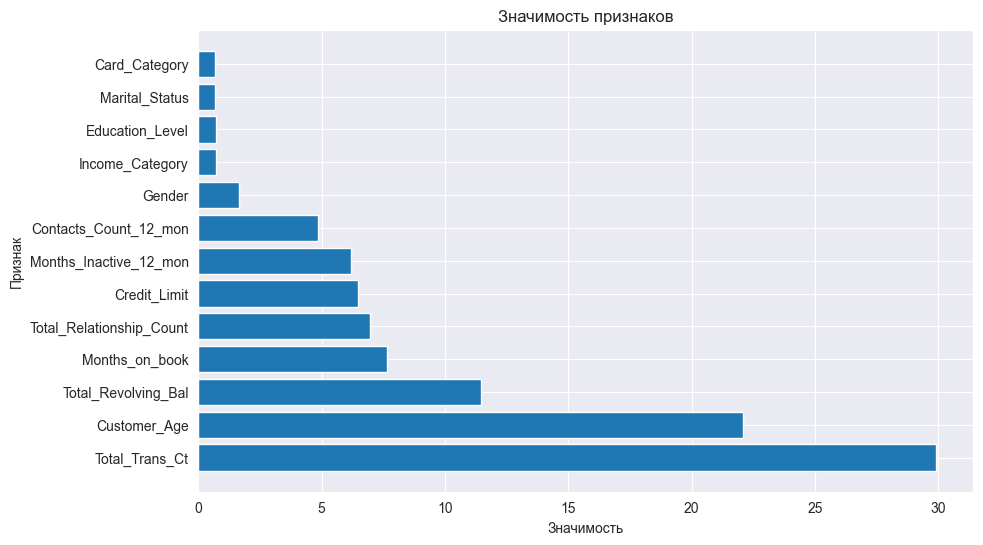

In [91]:
feature_importance_df = pd.DataFrame({'Признак': X_train.columns, 'Значимость': best_model.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Значимость', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Признак'], feature_importance_df['Значимость'])
plt.xlabel('Значимость')
plt.ylabel('Признак')
plt.title('Значимость признаков')
plt.show()

#### Выводы по прзнакам.

Из ожидаемых результатов - это то, что Total_Trans_Ct, количество транзакций. Чем чаще клиент пользуется услугами, тем меньше вероятность, что он уйдёт. Также не удевительно, что пол мало на что влияет.

Из неожиданного - это влияние возраста. Возможно, для каких-то категорий клиентов по возрастам у нас плохие условия. Также почему-то совсем не влияют категориальные признаки. Возможно, тут какие-то проблемы с предобработкой данных или моделью

## Общие выводы

Исследование показало плохие результы. Можно выделить следующие слабые места, которые можно улучшить:

1. Больше разобраться с данными. Например, с выбросами в Total_Trans_Ct или попробовать разные обработки категориальных признаков;
2. Заняться feature engineering и выделить больше информации - изначально в датасете присутствовало две таблицы. Вторая - это список транзакций. Она была выброшена по причине того, что для её использования нужна серьёзная предобработка.